**Install Required Libraries**

In [ ]:
!pip install torchdiffeq kagglehub requests

**Import Libraries**

In [ ]:
import torch
import torch.nn as nn
from torchdiffeq import odeint
import pandas as pd
import numpy as np
import requests
import datetime
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import kagglehub
from kagglehub import KaggleDatasetAdapter
from statsmodels.tsa.statespace.sarimax import SARIMAX

**Load Bitcoin Historical Data**

In [ ]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Load OHLCV data
bitcoin_df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "mczielinski/bitcoin-historical-data",
    "btcusd_1-min_data.csv"  # replace with actual file name
)

<ipython-input-3-1bb2b0e86653>:5: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  bitcoin_df = kagglehub.load_dataset(


In [ ]:
print(bitcoin_df.columns)
bitcoin_df.head(10)

Index(['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')


,Timestamp,Open,High,Low,Close,Volume
0,1.325412e+09,4.58,4.58,4.58,4.58,0.0
1,1.325412e+09,4.58,4.58,4.58,4.58,0.0
2,1.325412e+09,4.58,4.58,4.58,4.58,0.0
3,1.325412e+09,4.58,4.58,4.58,4.58,0.0
4,1.325412e+09,4.58,4.58,4.58,4.58,0.0
5,1.325412e+09,4.58,4.58,4.58,4.58,0.0
6,1.325412e+09,4.58,4.58,4.58,4.58,0.0
7,1.325412e+09,4.58,4.58,4.58,4.58,0.0
8,1.325413e+09,4.58,4.58,4.58,4.58,0.0
9,1.325413e+09,4.58,4.58,4.58,4.58,0.0


In [ ]:
import pandas as pd

# Parse datetime and set as index
bitcoin_df['datetime'] = pd.to_datetime(bitcoin_df['Timestamp'], unit='s')
bitcoin_df.set_index('datetime', inplace=True)

# Drop rows with missing prices (if any)
bitcoin_df.dropna(subset=['Open', 'High', 'Low', 'Close'], inplace=True)

# Resample to daily OHLCV
daily_df = bitcoin_df.resample('1D').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
})

# Drop days where price is completely missing
daily_df.dropna(inplace=True)

daily_df.head(10)


,Open,High,Low,Close,Volume
datetime,,,,,
2012-01-01,4.58,4.84,4.58,4.84,10.000000
2012-01-02,4.84,5.00,4.84,5.00,10.100000
2012-01-03,5.00,5.32,5.00,5.29,107.085281
2012-01-04,5.29,5.57,4.93,5.57,107.233260
2012-01-05,5.57,6.46,5.57,6.42,70.328742
2012-01-06,6.42,6.90,6.40,6.40,55.855834
2012-01-07,6.40,6.80,6.00,6.80,2.795858
2012-01-08,6.80,6.90,6.80,6.90,4.000000
2012-01-09,6.90,7.00,6.36,6.48,64.869323


**Fetch Fear-and-Greed Index Data**

In [ ]:
def fetch_fear_and_greed_index(limit=0):
    url = f"https://api.alternative.me/fng/?limit={limit}&format=json"
    response = requests.get(url)
    data = response.json()['data']

    records = []
    for d in data:
        ts = datetime.datetime.fromtimestamp(int(d['timestamp']))
        records.append({'date': ts.date(), 'fgi': int(d['value'])})

    fgi_df = pd.DataFrame(records)
    fgi_df = fgi_df.drop_duplicates(subset='date').sort_values('date')
    fgi_df['date'] = pd.to_datetime(fgi_df['date'])
    fgi_df.set_index('date', inplace=True)
    return fgi_df

fgi_df = fetch_fear_and_greed_index(limit=0)  # all available
fgi_df.head(10)


,fgi
date,
2018-02-01,30
2018-02-02,15
2018-02-03,40
2018-02-04,24
2018-02-05,11
2018-02-06,8
2018-02-07,36
2018-02-08,30
2018-02-09,44


In [ ]:
# prompt: clean nas from the fgi and fill it with the previous value

fgi_df['fgi'] = fgi_df['fgi'].ffill()

**Merge & Scale Datasets**

In [ ]:
fgi_df.index = fgi_df.index.tz_localize('UTC')
daily_df.index = daily_df.index.tz_localize('UTC')

# Merge by date
merged_df = daily_df.merge(fgi_df, left_index=True, right_index=True, how='inner')

# ✅ Filter to only include dates from January 1, 2022 onwards
merged_df = merged_df[merged_df.index >= '2018-02-01']

# Drop rows with NaNs
merged_df.dropna(inplace=True)

# Normalize all features
features = ['Open', 'High', 'Low', 'Close', 'fgi']
scaler = StandardScaler()
scaled_data = scaler.fit_transform(merged_df[features])
scaled_df = pd.DataFrame(scaled_data, columns=features, index=merged_df.index)

# Target: next-day Close
scaled_df['Target'] = scaled_df['Close'].shift(-1)
scaled_df.dropna(inplace=True)

scaled_df.head(10)


,Open,High,Low,Close,fgi,Target
2018-02-01 00:00:00+00:00,-0.830686,-0.833806,-0.863311,-0.868728,-0.789928,-0.883388
2018-02-02 00:00:00+00:00,-0.868508,-0.868994,-0.909270,-0.883388,-1.477272,-0.853064
2018-02-03 00:00:00+00:00,-0.884272,-0.861249,-0.888304,-0.853064,-0.331699,-0.893851
2018-02-04 00:00:00+00:00,-0.852652,-0.859505,-0.887589,-0.893851,-1.064866,-0.947381
2018-02-05 00:00:00+00:00,-0.893664,-0.899185,-0.938466,-0.947381,-1.660564,-0.936679
2018-02-06 00:00:00+00:00,-0.947262,-0.933473,-0.974786,-0.936679,-1.798033,-0.896191
2018-02-07 00:00:00+00:00,-0.936257,-0.890587,-0.927138,-0.896191,-0.514990,-0.896971
2018-02-08 00:00:00+00:00,-0.896007,-0.890759,-0.912421,-0.896971,-0.789928,-0.881799
2018-02-09 00:00:00+00:00,-0.896808,-0.885767,-0.904347,-0.881799,-0.148407,-0.893086
2018-02-10 00:00:00+00:00,-0.881596,-0.874282,-0.885103,-0.893086,0.309823,-0.892965


**Define Neural ODE Architecture**

In [ ]:
import torch
import torch.nn as nn
from torchdiffeq import odeint

# ODE function representing dH/dt = f(H, t)
class ODEFunc(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, t, h):
        return self.net(h)

# Neural ODE wrapper
class NeuralODE(nn.Module):
    def __init__(self, ode_func):
        super(NeuralODE, self).__init__()
        self.ode_func = ode_func

    def forward(self, h0, t):
        return odeint(self.ode_func, h0, t)  # Output shape: [time_steps, batch_size, dim]


**Prepare the Dataset (Sliding Window Format)**

In [ ]:
import numpy as np

# Parameters
n_steps = 30  # How many days of history to feed
features = ['Open', 'High', 'Low', 'Close', 'fgi']
target_col = 'Target'

# Convert to numpy
data = scaled_df[features].values
target = scaled_df[target_col].values

# Prepare sequences and targets
X, y = [], []
for i in range(len(data) - n_steps):
    X.append(data[i:i+n_steps])
    y.append(target[i+n_steps])

X = np.array(X)
y = np.array(y)

print(f"Input shape: {X.shape}, Target shape: {y.shape}")


Input shape: (2646, 30, 5), Target shape: (2646,)


**Convert to PyTorch Tensors**

In [ ]:
# Convert to torch tensors
# Convert to torch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)         # [batch, time, features]
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # [batch, 1]


**Train-Test Split**

In [ ]:
# New 70/15/15 split
train_end = int(0.7 * len(X_tensor))
val_end = int(0.85 * len(X_tensor))

X_train, X_val, X_test = X_tensor[:train_end], X_tensor[train_end:val_end], X_tensor[val_end:]
y_train, y_val, y_test = y_tensor[:train_end], y_tensor[train_end:val_end], y_tensor[val_end:]


**Define Full Neural ODE Model for Regression**

In [ ]:
class ODEBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(ODEBlock, self).__init__()
        self.ode_func = ODEFunc(input_dim, hidden_dim)
        self.ode = NeuralODE(self.ode_func)

    def forward(self, x):
        # x: [batch, time, features]
        batch_size, time_steps, input_dim = x.size()

        # Transpose for odeint: [time, batch, features]
        x = x.transpose(0, 1)

        # Initial state: first time step
        h0 = x[0]

        # Time vector: assume uniform time intervals
        t = torch.linspace(0, 1, steps=time_steps).to(x.device)

        out = self.ode(h0, t)  # [time, batch, features]
        final_state = out[-1]  # Last time step
        return final_state  # [batch, features]

class NeuralODERegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(NeuralODERegressor, self).__init__()
        self.odeblock = ODEBlock(input_dim, hidden_dim)
        self.fc = nn.Linear(input_dim, 1)

    def forward(self, x):
        h_last = self.odeblock(x)
        out = self.fc(h_last)
        return out


**Training Loopo**

In [ ]:
# Hyperparameters
input_dim = X_train.shape[2]
hidden_dim = 16
lr = 1e-4
epochs = 900

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
neural_ode_model = NeuralODERegressor(input_dim, hidden_dim).to(device)
optimizer = torch.optim.Adam(neural_ode_model.parameters(), lr=lr)
criterion = nn.MSELoss()

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Send validation tensors to device
X_val, y_val = X_val.to(device), y_val.to(device)

train_losses = []
val_losses = []

best_val_loss = float('inf')
best_model_state = None


for epoch in range(epochs):
    neural_ode_model.train()
    optimizer.zero_grad()

    output = neural_ode_model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    if (epoch + 1) % 5 == 0 or epoch == 0:
        neural_ode_model.eval()
        with torch.no_grad():
            val_pred = neural_ode_model(X_val)
            val_loss = criterion(val_pred, y_val)
            test_pred = neural_ode_model(X_test)
            test_loss = criterion(test_pred, y_test)
            val_losses.append(val_loss.item())

            # Save model if it's the best so far
            if val_loss.item() < best_val_loss:
                best_val_loss = val_loss.item()
                best_model_state = neural_ode_model.state_dict()

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Test Loss: {test_loss.item():.4f}")

# Load the best model based on validation loss
neural_ode_model.load_state_dict(best_model_state)


Epoch 1/900 - Train Loss: 0.6462, Val Loss: 0.4047, Test Loss: 3.2795
Epoch 5/900 - Train Loss: 0.6365, Val Loss: 0.4020, Test Loss: 3.2562
Epoch 10/900 - Train Loss: 0.6245, Val Loss: 0.3988, Test Loss: 3.2273
Epoch 15/900 - Train Loss: 0.6126, Val Loss: 0.3955, Test Loss: 3.1986
Epoch 20/900 - Train Loss: 0.6008, Val Loss: 0.3924, Test Loss: 3.1701
Epoch 25/900 - Train Loss: 0.5892, Val Loss: 0.3892, Test Loss: 3.1419
Epoch 30/900 - Train Loss: 0.5778, Val Loss: 0.3861, Test Loss: 3.1138
Epoch 35/900 - Train Loss: 0.5665, Val Loss: 0.3831, Test Loss: 3.0861
Epoch 40/900 - Train Loss: 0.5554, Val Loss: 0.3801, Test Loss: 3.0585
Epoch 45/900 - Train Loss: 0.5445, Val Loss: 0.3772, Test Loss: 3.0313
Epoch 50/900 - Train Loss: 0.5337, Val Loss: 0.3743, Test Loss: 3.0043
Epoch 55/900 - Train Loss: 0.5231, Val Loss: 0.3714, Test Loss: 2.9775
Epoch 60/900 - Train Loss: 0.5127, Val Loss: 0.3686, Test Loss: 2.9510
Epoch 65/900 - Train Loss: 0.5024, Val Loss: 0.3658, Test Loss: 2.9247
Epoch 70

<All keys matched successfully>

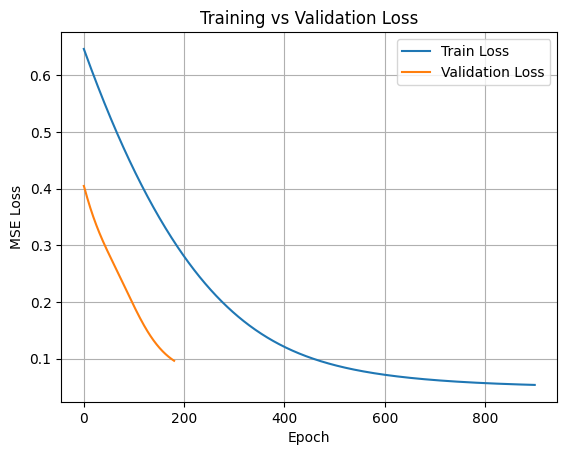

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()


**Define a Rolling Forecast Function**

In [ ]:
def rolling_forecast(model, initial_sequence, n_days=30):
    """
    Performs recursive forecasting for n_days based on initial_sequence.
    - model: trained NeuralODERegressor
    - initial_sequence: shape [1, time_steps, features]
    - returns: array of predictions
    """
    model.eval()
    input_seq = initial_sequence.clone().detach()  # clone to avoid modifying original
    predictions = []

    for _ in range(n_days):
        with torch.no_grad():
            pred = model(input_seq)  # shape: [1, 1]
            predictions.append(pred.item())

        # Append prediction as new "Close", keep others unchanged (optional trick)
        # Here, we update only the 'Close' column (index 3)
        new_day = input_seq[:, -1, :].clone()
        new_day[:, 3] = pred  # update Close
        input_seq = torch.cat([input_seq[:, 1:, :], new_day.unsqueeze(1)], dim=1)

    return predictions


**Select a Starting Point (last sequence in X_test)**


In [ ]:
# Pick the last known sequence from test set
initial_seq = X_test[-1].unsqueeze(0).to(device)  # shape: [1, n_steps, features]

# Generate 30-day forecast
forecast_30 = rolling_forecast(neural_ode_model, initial_seq, n_days=30)


In [ ]:
# Convert forecast_30 to real price (USD)
forecast_full = np.zeros((30, 5))
forecast_full[:, 3] = forecast_30  # only 'Close'

forecast_real = scaler.inverse_transform(forecast_full)[:, 3]

# Get true values from real test data
true_30 = scaled_df['Close'].iloc[-30:]
true_full = np.zeros((30, 5))
true_full[:, 3] = true_30
true_real = scaler.inverse_transform(true_full)[:, 3]

# Compute metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate MSE first, then take the square root for RMSE
neural_ode_30_mse = mean_squared_error(true_real, forecast_real)
neural_ode_30_rmse = np.sqrt(neural_ode_30_mse) # Manually compute RMSE
neural_ode_30_mae = mean_absolute_error(true_real, forecast_real)
print(f"Neural ODE (30-day) RMSE: {neural_ode_30_rmse:.2f}, MAE: {neural_ode_30_mae:.2f}")

Neural ODE (30-day) RMSE: 42286.41, MAE: 42042.90


**Plot the Rolling Forecast**

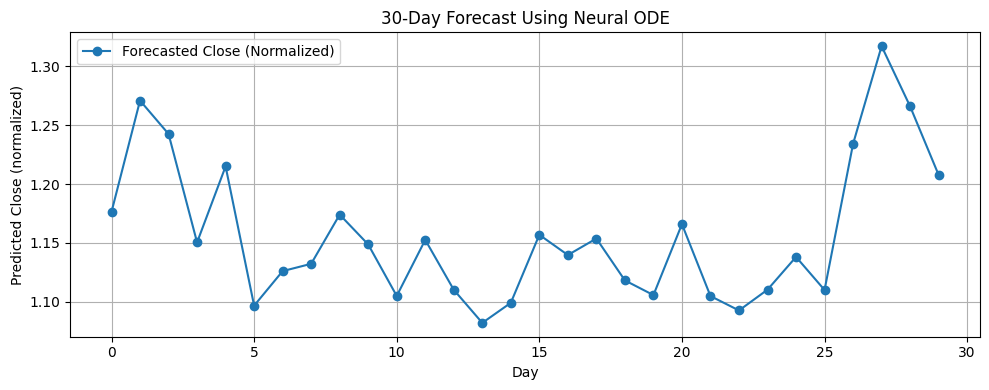

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(forecast_30, label='Forecasted Close (Normalized)', marker='o')
plt.title('30-Day Forecast Using Neural ODE')
plt.xlabel('Day')
plt.ylabel('Predicted Close (normalized)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


**Evaluate Predictions**

In [ ]:
test_pred = neural_ode_model(X_test).detach().cpu().numpy()
y_true = y_test.detach().cpu().numpy()


**RMSE (Root Mean Squared Error)**

**MAE (Mean Absolute Error)**

**MDA (Mean Directional Accuracy)**

**Optional: Visualize Predictions**

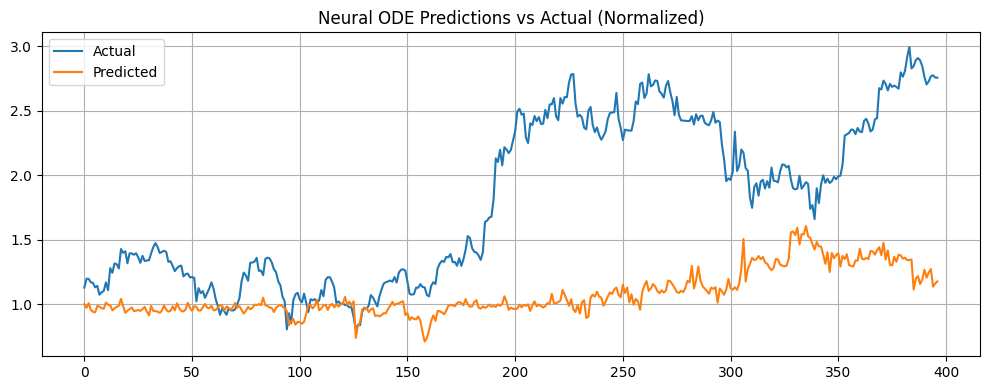

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(y_true, label='Actual')
plt.plot(test_pred, label='Predicted')
plt.title('Neural ODE Predictions vs Actual (Normalized)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


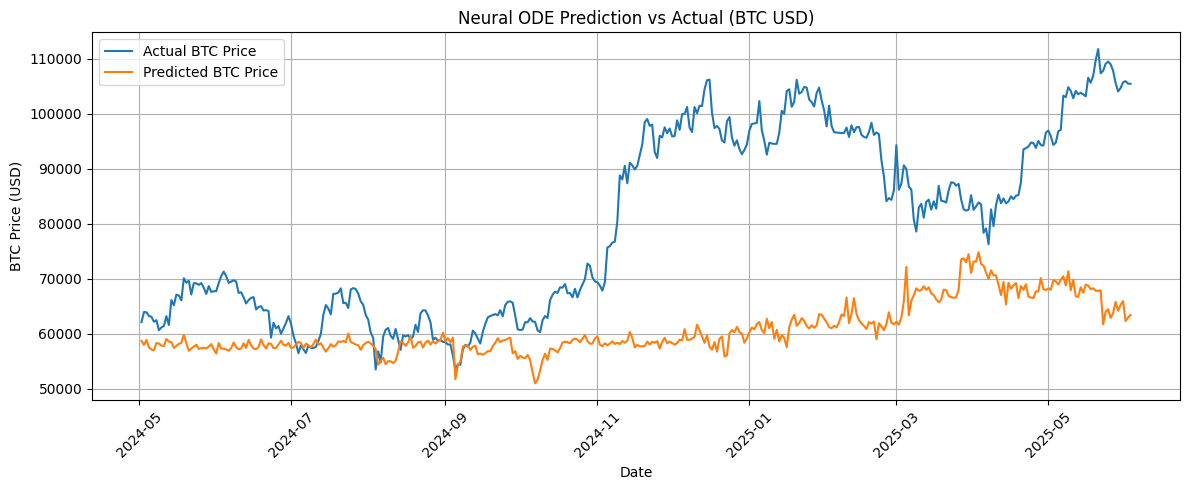

In [ ]:
# Inverse transform predictions (assuming 'Close' is 4th column in original features)
y_true_full = np.zeros((len(y_true), 5))  # Dummy array for all 5 features
y_true_full[:, 3] = y_true.flatten()     # Assign predicted Close
y_pred_full = np.zeros((len(test_pred), 5))
y_pred_full[:, 3] = test_pred.flatten()

y_true_real = scaler.inverse_transform(y_true_full)[:, 3]
y_pred_real = scaler.inverse_transform(y_pred_full)[:, 3]

# Reconstruct the actual dates for the test set
test_dates = scaled_df.index[-len(y_true):]  # Or use merged_df if you prefer original unscaled index

# Plot with real dates on X-axis
plt.figure(figsize=(12, 5))
plt.plot(test_dates, y_true_real, label='Actual BTC Price')
plt.plot(test_dates, y_pred_real, label='Predicted BTC Price')
plt.title('Neural ODE Prediction vs Actual (BTC USD)')
plt.xlabel('Date')
plt.ylabel('BTC Price (USD)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
print(len(test_dates), len(y_pred_real))  # Should be equal

397 397


In [ ]:
# Denormalize y_true and test_pred
neural_ode_y_true_full = np.zeros((len(y_true), 5))  # 5 features
neural_ode_test_pred_full = np.zeros((len(test_pred), 5))

neural_ode_y_true_full[:, 3] = y_true.flatten()  # 'Close' column
# test_pred is already a numpy array, no need to detach or convert to numpy again
neural_ode_test_pred_full[:, 3] = test_pred.flatten()

neural_ode_y_true_real = scaler.inverse_transform(neural_ode_y_true_full)[:, 3]
neural_ode_test_pred_real = scaler.inverse_transform(neural_ode_test_pred_full)[:, 3]

# Recalculate RMSE/MAE
from sklearn.metrics import mean_squared_error, mean_absolute_error

neural_ode_rmse = np.sqrt(mean_squared_error(neural_ode_y_true_real, neural_ode_test_pred_real))
neural_ode_mae = mean_absolute_error(neural_ode_y_true_real, neural_ode_test_pred_real)

**LSTM Model Class**

In [ ]:
class LSTMRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=1):
        super(LSTMRegressor, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=1, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, 1)


    def forward(self, x):
        out, _ = self.lstm(x)  # out: [batch, time, hidden_dim]
        last_output = out[:, -1, :]  # Take the last time step's output
        return self.fc(last_output)  # Predict final value


**Train and Evaluate (LSTM)**

In [ ]:
input_dim = X_train.shape[2]
hidden_dim = 256
epochs = 600
lr = 1e-3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Ensure device is defined if not global
lstm_model = LSTMRegressor(input_dim, hidden_dim).to(device)
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=lr)
criterion = nn.MSELoss()

X_train, y_train = X_train.to(device), y_train.to(device) # Ensure these are on the correct device
X_val, y_val = X_val.to(device), y_val.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)


train_losses = []
val_losses = []

# Reset best_val_loss and best_model_state specifically for the LSTM
best_val_loss_lstm = float('inf')
best_model_state_lstm = None


for epoch in range(epochs):
    lstm_model.train()
    optimizer.zero_grad()
    pred = lstm_model(X_train)
    loss = criterion(pred, y_train)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    lstm_model.eval()
    with torch.no_grad():
        val_pred = lstm_model(X_val)
        val_loss = criterion(val_pred, y_val)
        val_losses.append(val_loss.item())

        # Save best LSTM model state based on LSTM's validation loss
        if val_loss.item() < best_val_loss_lstm: # Use best_val_loss_lstm
            best_val_loss_lstm = val_loss.item()
            best_model_state_lstm = lstm_model.state_dict() # Use best_model_state_lstm

    if (epoch + 1) % 5 == 0 or epoch == 0:
        test_pred = lstm_model(X_test)
        test_loss = criterion(test_pred, y_test)
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Test Loss: {test_loss.item():.4f}")

# Load the best LSTM model based on its validation loss
if best_model_state_lstm is not None: # Ensure a best state was saved
    lstm_model.load_state_dict(best_model_state_lstm)
else:
    print("Warning: No best LSTM model state was saved (e.g., no improvement during training). Using the last epoch's state.")

Epoch 1/600 - Train Loss: 0.6031, Val Loss: 0.3031, Test Loss: 3.3221
Epoch 5/600 - Train Loss: 0.2987, Val Loss: 0.2061, Test Loss: 2.4044
Epoch 10/600 - Train Loss: 0.1071, Val Loss: 0.1309, Test Loss: 1.5793
Epoch 15/600 - Train Loss: 0.0711, Val Loss: 0.0809, Test Loss: 1.0691
Epoch 20/600 - Train Loss: 0.0258, Val Loss: 0.0124, Test Loss: 0.3033
Epoch 25/600 - Train Loss: 0.0211, Val Loss: 0.0270, Test Loss: 0.0778
Epoch 30/600 - Train Loss: 0.0059, Val Loss: 0.0065, Test Loss: 0.2043
Epoch 35/600 - Train Loss: 0.0085, Val Loss: 0.0135, Test Loss: 0.3224
Epoch 40/600 - Train Loss: 0.0056, Val Loss: 0.0097, Test Loss: 0.2842
Epoch 45/600 - Train Loss: 0.0053, Val Loss: 0.0059, Test Loss: 0.2232
Epoch 50/600 - Train Loss: 0.0039, Val Loss: 0.0059, Test Loss: 0.2068
Epoch 55/600 - Train Loss: 0.0044, Val Loss: 0.0064, Test Loss: 0.2061
Epoch 60/600 - Train Loss: 0.0039, Val Loss: 0.0059, Test Loss: 0.2043
Epoch 65/600 - Train Loss: 0.0040, Val Loss: 0.0059, Test Loss: 0.2158
Epoch 70

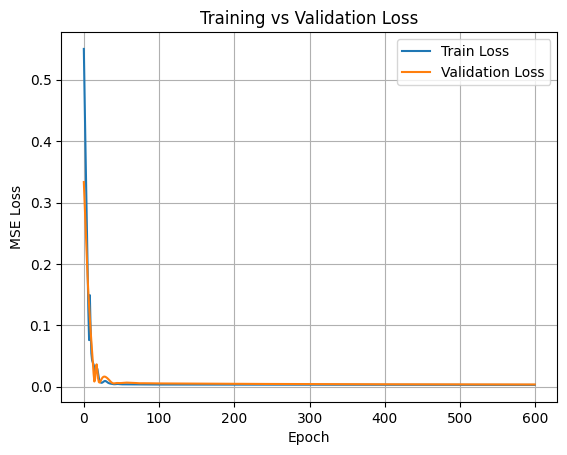

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()


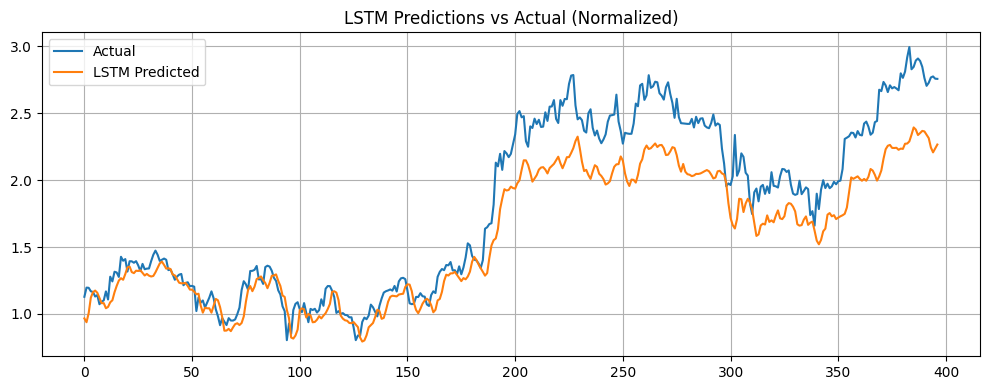

In [ ]:
# Assuming lstm_model is your trained LSTM and X_test, y_test are your test tensors

# Get predictions from LSTM model
lstm_pred = lstm_model(X_test).detach().cpu().numpy()
y_true = y_test.detach().cpu().numpy()

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(y_true, label='Actual')
plt.plot(lstm_pred, label='LSTM Predicted')
plt.title('LSTM Predictions vs Actual (Normalized)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
def rolling_forecast_lstm(model, initial_sequence, n_days=30):
    """
    Performs recursive forecasting for n_days using LSTM.
    :param model: trained LSTMRegressor model
    :param initial_sequence: shape [1, time_steps, features]
    :return: list of predicted Close values (normalized)
    """
    model.eval()
    input_seq = initial_sequence.clone().detach()
    predictions = []

    for _ in range(n_days):
        print(input_seq)
        with torch.no_grad():
            pred = model(input_seq)  # shape: [1, 1]
            predictions.append(pred.item())

        # Prepare next input sequence
        new_day = input_seq[:, -1, :].clone()
        new_day[:, 0] = pred  # Open = predicted Close
        new_day[:, 1] = pred  # High = predicted Close
        new_day[:, 2] = pred  # Low = predicted Close
        new_day[:, 3] = pred  # Close = predicted Close
        # fgi stays constant or can be shifted (optional)
        input_seq = torch.cat([input_seq[:, 1:, :], new_day.unsqueeze(1)], dim=1)

    return predictions


In [ ]:
initial_seq_lstm = X_test[-1].unsqueeze(0).to(device)
forecast_30_lstm = rolling_forecast_lstm(lstm_model, initial_seq_lstm, n_days=30)


tensor([[[2.4015, 2.3441, 2.4169, 2.3394, 0.7681],
         [2.3432, 2.3036, 2.3934, 2.3548, 0.2182],
         [2.3591, 2.3662, 2.3867, 2.4333, 0.5389],
         [2.4378, 2.3965, 2.4808, 2.4423, 0.9055],
         [2.4470, 2.6343, 2.5224, 2.6757, 0.8139],
         [2.6794, 2.6407, 2.7316, 2.6655, 1.1805],
         [2.6703, 2.6648, 2.7507, 2.7338, 1.0430],
         [2.7387, 2.6638, 2.7708, 2.7083, 1.0430],
         [2.7134, 2.6914, 2.6707, 2.6582, 1.0430],
         [2.6629, 2.6652, 2.6979, 2.7085, 1.0430],
         [2.7130, 2.6416, 2.7421, 2.6858, 1.1805],
         [2.6899, 2.6352, 2.6967, 2.6957, 1.0430],
         [2.7007, 2.6495, 2.7619, 2.6849, 1.0888],
         [2.6895, 2.6181, 2.7439, 2.6716, 1.2263],
         [2.6771, 2.7257, 2.7623, 2.7982, 1.2263],
         [2.8031, 2.7434, 2.7230, 2.7644, 1.2263],
         [2.7696, 2.7517, 2.8040, 2.8108, 1.0888],
         [2.8170, 2.8768, 2.8774, 2.9170, 1.0430],
         [2.9226, 2.9237, 2.9969, 2.9945, 1.1346],
         [2.9996, 2.9169, 2.903

In [ ]:
lstm_forecast_full = np.zeros((30, 5))
lstm_forecast_full[:, 3] = forecast_30_lstm
lstm_forecast_real = scaler.inverse_transform(lstm_forecast_full)[:, 3]

# Calculate MSE first, then take the square root for RMSE
lstm_30_mse = mean_squared_error(true_real, lstm_forecast_real)
lstm_30_rmse = np.sqrt(lstm_30_mse) # Manually compute RMSE
lstm_30_mae = mean_absolute_error(true_real, lstm_forecast_real)
print(f"LSTM (30-day) RMSE: {lstm_30_rmse:.2f}, MAE: {lstm_30_mae:.2f}")


LSTM (30-day) RMSE: 45483.49, MAE: 43548.63


In [ ]:
# lstm_model.eval()
# with torch.no_grad():
#     lstm_test_pred = lstm_model(X_test).detach().cpu().numpy()
#     lstm_y_true = y_test.detach().cpu().numpy()

# lstm_rmse = np.sqrt(mean_squared_error(lstm_y_true, lstm_test_pred))
# lstm_mae = mean_absolute_error(lstm_y_true, lstm_test_pred)

# print(f"LSTM - RMSE: {lstm_rmse:.4f}, MAE: {lstm_mae:.4f}")


**ARIMAX**

In [ ]:
# from statsmodels.tsa.statespace.sarimax import SARIMAX

# # Use raw Close as target and fgi as exogenous input
# raw_df = merged_df[['Close', 'fgi']].copy().dropna()
# raw_df.index = pd.DatetimeIndex(raw_df.index)
# raw_df = raw_df.asfreq('D').dropna()


# # Train/test split
# train_size = int(0.85 * len(raw_df))
# train_data = raw_df.iloc[:train_size]
# test_data = raw_df.iloc[train_size:]

# # Fit ARIMAX
# model = SARIMAX(train_data['Close'], exog=train_data[['fgi']], order=(5, 1, 0))  # order can be tuned
# arimax_fit = model.fit(disp=False)


In [ ]:
# # from statsmodels.tsa.statespace.sarimax import SARIMAX

# # def forecast_arimax_once(endog_train, exog_train, exog_forecast,
# #                          model_order=(1, 1, 1), seasonal_order=(1, 0, 1, 7),
# #                          n_days=30):
# #     """
# #     Forecast 30 days using ARIMAX without retraining on each step.
# #     :param endog_train: pd.Series of Close prices (training set)
# #     :param exog_train: pd.DataFrame of FGI for training
# #     :param exog_forecast: pd.DataFrame of FGI for the forecast period (30 rows)
# #     :return: List of predicted Close prices (length = 30)
# #     """
# #     model = SARIMAX(
# #         endog=endog_train,
# #         exog=exog_train,
# #         order=model_order,
# #         seasonal_order=seasonal_order,
# #         enforce_stationarity=False,
# #         enforce_invertibility=False
# #     )

# #     results = model.fit(disp=False)

# #     forecast = results.get_forecast(steps=n_days, exog=exog_forecast)
# #     return forecast.predicted_mean.tolist()


# def recursive_sarimax_forecast(endog_train, exog_train, exog_future,
#                                 model_order=(1,1,1), seasonal_order=(1,0,1,7),
#                                 n_days=30):
#     """
#     Recursive 30-day forecast using SARIMAX, updating inputs with own predictions.
#     """
#     preds = []
#     history_y = endog_train.copy()
#     history_x = exog_train.copy()

#     # Ensure index alignment
#     history_x = history_x.loc[history_y.index]

#     for i in range(n_days):
#         # Fit model once per step
#         model = SARIMAX(history_y, exog=history_x,
#                         order=model_order,
#                         seasonal_order=seasonal_order,
#                         enforce_stationarity=False,
#                         enforce_invertibility=False)
#         result = model.fit(disp=False)

#         # Grab next exog
#         next_exog = exog_future.iloc[i:i+1]
#         if next_exog.empty:
#             break

#         # Predict next day
#         forecast = result.predict(start=len(history_y), end=len(history_y), exog=next_exog)
#         pred = forecast.values[0]
#         preds.append(pred)

#         # Update training data with prediction
#         next_date = next_exog.index[0]
#         history_y.loc[next_date] = pred
#         history_x.loc[next_date] = next_exog.iloc[0]

#     return preds


In [ ]:
# Split again (just to be sure)
raw_df = scaled_df[['Close', 'fgi']].copy().dropna()
raw_df.index = pd.DatetimeIndex(raw_df.index)
raw_df = raw_df.asfreq('D').dropna()

# Ensure a regular daily frequency
raw_df.index = pd.date_range(start=raw_df.index[0], periods=len(raw_df), freq='D')

# Double check
print(raw_df.index.freq)  # Should output: <Day>

train_size = int(0.85 * len(raw_df))
endog_train = raw_df['Close'].iloc[:train_size]
exog_train = raw_df[['fgi']].iloc[:train_size]
exog_future = raw_df[['fgi']].iloc[train_size:]  # where we will draw future FGI from


<Day>


In [ ]:
import statsmodels.api as sm

import itertools

p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

best_aic = float('inf')
best_order = None
for order in pdq:
    try:
        model = sm.tsa.SARIMAX(endog_train, exog=exog_train, order=order, seasonal_order=(1, 0, 1, 7))
        results = model.fit(disp=False)
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = order
    except:
        continue

print("Best ARIMA order:", best_order)


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

Best ARIMA order: (1, 1, 0)


In [ ]:
# Define and fit SARIMAX model (ARIMA with exogenous regressors)
model = sm.tsa.SARIMAX(
    endog=endog_train,
    exog=exog_train,
    order=best_order,             # Adjust as needed
    seasonal_order=(1,0,1,7), # Omit seasonality for now
    enforce_stationarity=False,
    enforce_invertibility=False
)

# Fit the model
model_fit = model.fit(disp=False)

# Forecasting future values
# Use exog_future instead of exog_test
n_steps = len(exog_future)  # how many steps to forecast
forecast = model_fit.forecast(steps=n_steps, exog=exog_future) # Use exog_future here as well

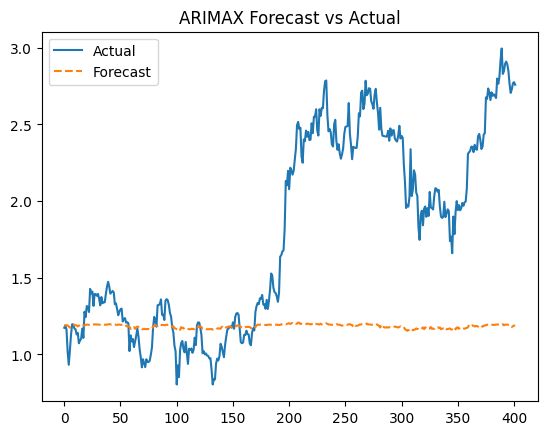

In [ ]:
import matplotlib.pyplot as plt

# Define endog_test
# Assuming train_size is the split point defined previously
endog_test = raw_df['Close'].iloc[train_size:]


plt.plot(range(len(endog_test)), endog_test, label='Actual')
plt.plot(range(len(forecast)), forecast, label='Forecast', linestyle='--')
plt.legend()
plt.title("ARIMAX Forecast vs Actual")
plt.show()

In [ ]:
# exog_future_30 = exog_future.iloc[:30]

# forecast_30_arimax_recursive = recursive_sarimax_forecast(
#     endog_train=endog_train,
#     exog_train=exog_train,
#     exog_future=exog_future_30,
#     model_order=(1,1,1),
#     seasonal_order=(1,0,1,7),
#     n_days=30
# )

# true_real = raw_df['Close'].iloc[train_size:train_size+30].values


In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# days = np.arange(1, 31)
# plt.figure(figsize=(10, 5))
# plt.plot(days, true_real, label='Actual', linewidth=2)
# plt.plot(days, forecast_30_arimax_recursive, label='SARIMAX (Recursive)', linestyle='--', marker='^')
# plt.title("Recursive SARIMAX 30-Day Forecast")
# plt.xlabel("Days Ahead")
# plt.ylabel("BTC Close Price (USD)")
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()


In [ ]:
# from sklearn.metrics import mean_squared_error, mean_absolute_error
# import numpy as np # Ensure numpy is imported for sqrt

# # Calculate MSE first
# arimax_30_mse = mean_squared_error(true_real, forecast_30_arimax_recursive)

# # Calculate RMSE by taking the square root of MSE
# arimax_30_rmse = np.sqrt(arimax_30_mse)

# arimax_30_mae = mean_absolute_error(true_real, forecast_30_arimax_recursive)
# print(f"ARIMAX (30-day) RMSE: {arimax_30_rmse:.2f}, MAE: {arimax_30_mae:.2f}")

**Summary Plot**

In [ ]:
# # Denormalize y_true and test_pred
# lstm_y_true_full = np.zeros((len(lstm_y_true), 5))
# lstm_test_pred_full = np.zeros((len(lstm_test_pred), 5))

# lstm_y_true_full[:, 3] = lstm_y_true.flatten()
# lstm_test_pred_full[:, 3] = lstm_test_pred.flatten()

# lstm_y_true_real = scaler.inverse_transform(lstm_y_true_full)[:, 3]
# lstm_test_pred_real = scaler.inverse_transform(lstm_test_pred_full)[:, 3]

# # Calculate MSE and then take the square root for RMSE
# # The 'squared' parameter is not supported in this sklearn version
# lstm_rmse = np.sqrt(mean_squared_error(lstm_y_true_real, lstm_test_pred_real))
# lstm_mae = mean_absolute_error(lstm_y_true_real, lstm_test_pred_real)

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# days = np.arange(1, 31)

# plt.figure(figsize=(12, 6))
# plt.plot(days, true_real, label="Actual", color="black", linewidth=2)
# plt.plot(days, forecast_real, label="Neural ODE", linestyle='--', marker='o')
# plt.plot(days, lstm_forecast_real, label="LSTM", linestyle='--', marker='s')
# plt.plot(days, forecast_30_arimax_recursive, label="ARIMAX (Seasonal)", linestyle='--', marker='^')

# plt.title("30-Day Forecast Comparison")
# plt.xlabel("Day")
# plt.ylabel("BTC Close Price (USD)")
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()


In [ ]:
# plt.figure(figsize=(10, 4))
# plt.plot(forecast_30, label='Forecasted Close (Normalized)', marker='o')
# plt.title('30-Day Forecast Using Neural ODE')
# plt.xlabel('Day')
# plt.ylabel('Predicted Close (normalized)')
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()

In [ ]:
# models = ['Neural ODE', 'LSTM', 'ARIMAX']
# rmses = [neural_ode_30_rmse, lstm_30_rmse, arimax_30_rmse]
# maes = [neural_ode_30_mae, lstm_30_mae, arimax_30_mae]

# plt.figure(figsize=(8, 4))
# x = np.arange(len(models))
# width = 0.35
# plt.bar(x - width/2, rmses, width, label='RMSE')
# plt.bar(x + width/2, maes, width, label='MAE')
# plt.xticks(x, models)
# plt.title('30-Day Forecast Accuracy (USD)')
# plt.ylabel('Error (USD)')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()


In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# days = np.arange(1, 31)

# plt.figure(figsize=(12, 5))
# plt.plot(days, true_real, label='Actual', color='black', linewidth=2)
# plt.plot(days, forecast_real, label='Neural ODE', linestyle='--', marker='o')
# plt.plot(days, lstm_forecast_real, label='LSTM', linestyle='--', marker='s')
# plt.plot(days, forecast_30_arimax_recursive, label='ARIMAX', linestyle='--', marker='^')

# plt.title('30-Day Forecast: Predicted vs Actual BTC Close Price')
# plt.xlabel('Days into Future')
# plt.ylabel('BTC Price (USD)')
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

all_features_scaled = scaled_df[['Open', 'High', 'Low', 'Close', 'fgi']].copy()
seq_len = 30
forecast_horizon = 30
step_size = 30

ode_rolling_preds = []
ode_rolling_dates = []

last_true_close = None
last_pred_close = None

for i in range(0, len(test_dates) - forecast_horizon + 1, forecast_horizon):
    train_end = train_size + i
    if train_end - seq_len < 0 or train_end + forecast_horizon > len(all_features_scaled):
        continue

    input_seq = all_features_scaled.iloc[train_end - seq_len : train_end].values

    # Bias correction
    if last_true_close is not None and last_pred_close is not None:
        bias = last_true_close - last_pred_close
    else:
        bias = 0

    pred_seq = []

    for step in range(forecast_horizon):
        if train_end + step >= len(all_features_scaled):
            break

        input_tensor = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0).to(device)
        pred = neural_ode_model(input_tensor).detach().cpu().numpy()[0, 0]

        # Apply decaying bias
        pred += bias

        pred_seq.append(pred)

        next_input = input_seq[-1].copy()
        next_input = input_seq[-1].copy()
        next_input[3] = pred  # Always use prediction
        input_seq = np.vstack([input_seq[1:], next_input])

    last_true_close = all_features_scaled.iloc[train_end + forecast_horizon - 1]['Close']
    last_pred_close = pred_seq[-1] - bias

    ode_rolling_preds.append(np.array(pred_seq))
    ode_rolling_dates.append(test_dates[i:i + forecast_horizon])


In [ ]:

# forecast_horizon_7 = 7
# step_size_7 = 7

# ode_rolling_preds_7 = []
# ode_rolling_dates_7 = []

# for i in range(0, len(test_dates) - forecast_horizon_7 + 1, step_size_7):
#     train_end = train_size + i

#     input_seq = all_features_scaled.iloc[train_end - seq_len : train_end].values

#     pred_seq = []

#     for _ in range(forecast_horizon_7):
#         input_tensor = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0).to(device)
#         pred = neural_ode_model(input_tensor).detach().cpu().numpy()[0, 0]

#         pred_seq.append(pred)

#         next_input = input_seq[-1].copy()
#         next_input[3] = pred  # Replace only Close price
#         input_seq = np.vstack([input_seq[1:], next_input])

#     # Denormalize predictions (Close at index 3)
#     # pred_full = np.zeros((forecast_horizon_7, 5))
#     # pred_full[:, 3] = pred_seq
#     # pred_real = scaler.inverse_transform(pred_full)[:, 3]

#     ode_rolling_preds_7.append(np.array(pred_seq))
#     ode_rolling_dates_7.append(test_dates[i:i + forecast_horizon_7])


In [ ]:

# forecast_horizon_1 = 1  # Predict only 1 day ahead
# step_size_1 = 1          # Slide by 1 day to get daily predictions

# ode_rolling_preds_1 = []
# ode_rolling_dates_1 = []

# for i in range(0, len(test_dates) - forecast_horizon_1 + 1, step_size_1):
#     train_end = train_size + i

#     # Get the 7-day input sequence
#     input_seq = all_features_scaled.iloc[train_end - seq_len : train_end].values

#     # Convert to tensor and predict 1 day ahead
#     input_tensor = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0).to(device)
#     pred = neural_ode_model(input_tensor).detach().cpu().numpy()[0, 0]

#     # Save prediction and corresponding date
#     ode_rolling_preds_1.append(pred)
#     ode_rolling_dates_1.append(test_dates[i])  # Only 1-day ahead, so one date


In [ ]:

# forecast_horizon_90 = 90
# step_size_90 = 90

# ode_rolling_preds_90 = []
# ode_rolling_dates_90 = []

# for i in range(0, len(test_dates) - forecast_horizon_90 + 1, step_size_90):
#     train_end = train_size + i

#     input_seq = all_features_scaled.iloc[train_end - seq_len : train_end].values

#     pred_seq = []

#     for _ in range(forecast_horizon_90):
#         input_tensor = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0).to(device)
#         pred = neural_ode_model(input_tensor).detach().cpu().numpy()[0, 0]

#         pred_seq.append(pred)

#         next_input = input_seq[-1].copy()
#         next_input[3] = pred  # Replace only the Close value
#         input_seq = np.vstack([input_seq[1:], next_input])

#     # Denormalize predictions if needed
#     # pred_full = np.zeros((forecast_horizon_90, 5))  # Adjust number of features if different
#     # pred_full[:, 3] = pred_seq
#     # pred_real = scaler.inverse_transform(pred_full)[:, 3]

#     ode_rolling_preds_90.append(np.array(pred_seq))
#     ode_rolling_dates_90.append(test_dates[i : i + forecast_horizon_90])


In [ ]:
# seq_len = 30

lstm_rolling_preds = []
lstm_rolling_dates = []

for i in range(0, len(test_dates) - forecast_horizon + 1, forecast_horizon):
    train_end = train_size + i
    # Ensure X_input is converted to numpy array
    X_input = all_features_scaled[train_end - seq_len:train_end].values  # <--- Convert to NumPy array

    pred_seq = []
    # input_seq is now a NumPy array
    input_seq = X_input.copy()

    for _ in range(forecast_horizon):
        # input_seq is a NumPy array, safe to convert to tensor
        input_tensor = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0).to(device)
        pred = lstm_model(input_tensor).detach().cpu().numpy()[0, 0]

        pred_seq.append(pred)

        # Append the prediction to the input sequence for next step
        next_input = input_seq[-1].copy()
        next_input[3] = pred
        # np.vstack returns a NumPy array, so input_seq remains a NumPy array
        input_seq = np.vstack([input_seq[1:], next_input])  # slide window

    # Inverse transform
    # pred_full = np.zeros((forecast_horizon, 5))
    # pred_full[:, 3] = pred_seq
    # pred_real = scaler.inverse_transform(pred_full)[:, 3]

    lstm_rolling_preds.append(np.array(pred_seq))
    lstm_rolling_dates.append(test_dates[i:i + forecast_horizon])

In [ ]:
# lstm_rolling_preds_7 = []
# lstm_rolling_dates_7 = []

# for i in range(0, len(test_dates) - forecast_horizon_7 + 1, forecast_horizon_7):
#     train_end = train_size + i
#     # Ensure X_input is converted to numpy array
#     X_input = all_features_scaled[train_end - seq_len:train_end].values  # <--- Convert to NumPy array

#     pred_seq = []
#     # input_seq is now a NumPy array
#     input_seq = X_input.copy()

#     for _ in range(forecast_horizon_7):
#         # input_seq is a NumPy array, safe to convert to tensor
#         input_tensor = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0).to(device)
#         pred = lstm_model(input_tensor).detach().cpu().numpy()[0, 0]

#         pred_seq.append(pred)

#         # Append the prediction to the input sequence for next step
#         next_input = input_seq[-1].copy()
#         next_input[3] = pred
#         # np.vstack returns a NumPy array, so input_seq remains a NumPy array
#         input_seq = np.vstack([input_seq[1:], next_input])  # slide window

#     # Inverse transform
#     # pred_full = np.zeros((forecast_horizon_7, 5))
#     # pred_full[:, 3] = pred_seq
#     # pred_real = scaler.inverse_transform(pred_full)[:, 3]

#     lstm_rolling_preds_7.append(np.array(pred_seq))
#     lstm_rolling_dates_7.append(test_dates[i:i + forecast_horizon_7])

In [ ]:
# forecast_horizon_1 = 1  # Predict only 1 day ahead
# step_size_1 = 1          # Slide by 1 day

# lstm_rolling_preds_1 = []
# lstm_rolling_dates_1 = []

# for i in range(0, len(test_dates) - forecast_horizon_1 + 1, step_size_1):
#     train_end = train_size + i

#     # Get 7-day input sequence
#     X_input = all_features_scaled[train_end - seq_len:train_end].values

#     input_tensor = torch.tensor(X_input, dtype=torch.float32).unsqueeze(0).to(device)
#     pred = lstm_model(input_tensor).detach().cpu().numpy()[0, 0]  # Predict 1 day

#     lstm_rolling_preds_1.append(pred)
#     lstm_rolling_dates_1.append(test_dates[i])  # Single date per prediction


In [ ]:
# lstm_rolling_preds_90 = []
# lstm_rolling_dates_90 = []

# for i in range(0, len(test_dates) - forecast_horizon_90 + 1, forecast_horizon_90):
#     train_end = train_size + i
#     # Ensure X_input is converted to numpy array
#     X_input = all_features_scaled[train_end - seq_len:train_end].values  # NumPy array

#     pred_seq = []
#     input_seq = X_input.copy()

#     for _ in range(forecast_horizon_90):
#         input_tensor = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0).to(device)
#         pred = lstm_model(input_tensor).detach().cpu().numpy()[0, 0]

#         pred_seq.append(pred)

#         # Update input_seq sliding window
#         next_input = input_seq[-1].copy()
#         next_input[3] = pred  # Assuming target is feature index 3
#         input_seq = np.vstack([input_seq[1:], next_input])

#     lstm_rolling_preds_90.append(np.array(pred_seq))
#     lstm_rolling_dates_90.append(test_dates[i:i + forecast_horizon_90])


In [ ]:
# prompt: plot the prediction of the validation datasets for all models

import matplotlib.pyplot as plt
import numpy as np

# Plot ARIMAX Predictions on Test Set
# ARIMAX was trained on raw data and predicted on raw data, so no scaling needed for its output
# We need to align ARIMAX test predictions with test_dates
# First, get the actual test data Close prices
arimax_true_test = scaled_df['Close'].iloc[train_size:]
# Fit ARIMAX on the training data
# Predict on the test data's exogenous variables
exog_future_full = scaled_df[['fgi']].iloc[train_size:]  # full test range, not just 30
# --- Rolling SARIMAX (ARIMAX + Seasonality) Forecasts Every 30 Days ---

sarimax_rolling_preds = []
sarimax_rolling_dates = []

for i in range(0, len(test_dates) - forecast_horizon + 1, step_size):
    train_end = train_size + i

    # Use scaled (normalized) values
    train_series = scaled_df['Close'].iloc[:train_end]
    train_exog = scaled_df[['fgi']].iloc[:train_end]
    future_exog = scaled_df[['fgi']].iloc[train_end:train_end + forecast_horizon]

    forecast_dates = test_dates[i:i + forecast_horizon]

    # Reindex for SARIMAX compatibility
    train_series.index = pd.date_range(start=train_series.index[0], periods=len(train_series), freq='D')
    train_exog.index = train_series.index

    try:
        model = sm.tsa.SARIMAX(
            train_series,
            exog=train_exog,
            order=best_order,
            seasonal_order=(1, 0, 1, 30),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        fitted_model = model.fit(disp=False)

        forecast = fitted_model.forecast(steps=forecast_horizon, exog=future_exog)

        # 🔁 DENORMALIZE the 'Close' predictions (which are in scaled form)
        # dummy = np.zeros((len(forecast), 5))  # assuming you scaled 5 columns
        # dummy[:, 3] = forecast.values  # index 3 = 'Close'
        # forecast_real = scaler.inverse_transform(dummy)[:, 3]

        # sarimax_rolling_preds.append(forecast_real)
        sarimax_rolling_preds.append(forecast.values)
        sarimax_rolling_dates.append(forecast_dates)
    except Exception as e:
        print(f"[Error] SARIMAX failed at step {i}: {e}")
        continue



In [ ]:
# sarimax_rolling_preds_7 = []
# sarimax_rolling_dates_7 = []

# for i in range(0, len(test_dates) - forecast_horizon_7 + 1, step_size_7):
#     train_end = train_size + i

#     # Use scaled (normalized) values
#     train_series = scaled_df['Close'].iloc[:train_end]
#     train_exog = scaled_df[['fgi']].iloc[:train_end]
#     future_exog = scaled_df[['fgi']].iloc[train_end:train_end + forecast_horizon_7]

#     forecast_dates = test_dates[i:i + forecast_horizon_7]

#     # Reindex for SARIMAX compatibility
#     train_series.index = pd.date_range(start=train_series.index[0], periods=len(train_series), freq='D')
#     train_exog.index = train_series.index

#     try:
#         model = sm.tsa.SARIMAX(
#             train_series,
#             exog=train_exog,
#             order=best_order,
#             seasonal_order=(1, 0, 1, 7),
#             enforce_stationarity=False,
#             enforce_invertibility=False
#         )
#         fitted_model = model.fit(disp=False)

#         forecast = fitted_model.forecast(steps=forecast_horizon_7, exog=future_exog)

#         # 🔁 DENORMALIZE the 'Close' predictions (which are in scaled form)
#         # dummy = np.zeros((len(forecast), 5))  # assuming you scaled 5 columns
#         # dummy[:, 3] = forecast.values  # index 3 = 'Close'
#         # forecast_real = scaler.inverse_transform(dummy)[:, 3]

#         # sarimax_rolling_preds_7.append(forecast_real)
#         sarimax_rolling_preds_7.append(forecast.values)
#         sarimax_rolling_dates_7.append(forecast_dates)
#     except Exception as e:
#         print(f"[Error] SARIMAX failed at step {i}: {e}")
#         continue

In [ ]:
# sarimax_rolling_preds_90 = []
# sarimax_rolling_dates_90 = []

# for i in range(0, len(test_dates) - forecast_horizon_90 + 1, step_size_90):
#     train_end = train_size + i

#     # Use scaled (normalized) values
#     train_series = scaled_df['Close'].iloc[:train_end]
#     train_exog = scaled_df[['fgi']].iloc[:train_end]
#     future_exog = scaled_df[['fgi']].iloc[train_end:train_end + forecast_horizon_90]

#     forecast_dates = test_dates[i:i + forecast_horizon_90]

#     # Reindex for SARIMAX compatibility
#     train_series.index = pd.date_range(start=train_series.index[0], periods=len(train_series), freq='D')
#     train_exog.index = train_series.index

#     try:
#         model = sm.tsa.SARIMAX(
#             train_series,
#             exog=train_exog,
#             order=best_order,
#             seasonal_order=(1, 0, 1, 7),
#             enforce_stationarity=False,
#             enforce_invertibility=False
#         )
#         fitted_model = model.fit(disp=False)

#         forecast = fitted_model.forecast(steps=forecast_horizon_90, exog=future_exog)

#         # If you want to denormalize, uncomment and adjust the following lines:
#         # dummy = np.zeros((len(forecast), 5))  # adjust number of columns as per your scaler
#         # dummy[:, 3] = forecast.values         # assuming index 3 corresponds to 'Close'
#         # forecast_real = scaler.inverse_transform(dummy)[:, 3]
#         # sarimax_rolling_preds_90.append(forecast_real)

#         sarimax_rolling_preds_90.append(forecast.values)
#         sarimax_rolling_dates_90.append(forecast_dates)
#     except Exception as e:
#         print(f"[Error] SARIMAX failed at step {i}: {e}")
#         continue


In [ ]:
# forecast_horizon_1 = 1  # One day ahead
# step_size_1 = 1         # Slide by 1 day

# sarimax_rolling_preds_1 = []
# sarimax_rolling_dates_1 = []

# for i in range(0, len(test_dates) - forecast_horizon_1 + 1, step_size_1):
#     train_end = train_size + i

#     # Get training series and exogenous input up to this point
#     train_series = scaled_df['Close'].iloc[:train_end]
#     train_exog = scaled_df[['fgi']].iloc[:train_end]
#     future_exog = scaled_df[['fgi']].iloc[train_end:train_end + forecast_horizon_1]

#     forecast_date = test_dates[i]  # Only one date for 1-day prediction

#     # Reindex for SARIMAX compatibility
#     train_series.index = pd.date_range(start=train_series.index[0], periods=len(train_series), freq='D')
#     train_exog.index = train_series.index

#     try:
#         model = sm.tsa.SARIMAX(
#             train_series,
#             exog=train_exog,
#             order=best_order,
#             seasonal_order=(1, 0, 1, 7),
#             enforce_stationarity=False,
#             enforce_invertibility=False
#         )
#         fitted_model = model.fit(disp=False)

#         forecast = fitted_model.forecast(steps=forecast_horizon_1, exog=future_exog)

#         sarimax_rolling_preds_1.append(forecast.values[0])  # store scalar
#         sarimax_rolling_dates_1.append(forecast_date)
#     except Exception as e:
#         print(f"[Error] SARIMAX failed at step {i}: {e}")
#         continue


In [ ]:
# plt.figure(figsize=(12, 6)) # You might want to set figure size before plotting
# # SARIMAX (already plotted)
# for pred, dates in zip(sarimax_rolling_preds, sarimax_rolling_dates):
#     plt.plot(dates, pred, color='orange', linestyle='--', alpha=0.7)
# plt.plot([], [], color='orange', linestyle='--', label='SARIMAX Rolling Forecasts')

# # LSTM
# for pred, dates in zip(lstm_rolling_preds, lstm_rolling_dates):
#     plt.plot(dates, pred, color='blue', linestyle='--', alpha=0.7)
# plt.plot([], [], color='blue', linestyle='--', label='LSTM Rolling Forecasts')

# # Neural ODE
# for pred, dates in zip(ode_rolling_preds, ode_rolling_dates):
#     plt.plot(dates, pred, color='green', linestyle='--', alpha=0.7)
# plt.plot([], [], color='green', linestyle='--', label='Neural ODE Rolling Forecasts')

# # Get the actual values corresponding to the full test_dates range
# # true_real was previously defined for only the first 30 days.
# # We need the actual 'Close' prices from the raw_df for the entire test period.
# full_test_true_real = raw_df['Close'].iloc[train_size:train_size + len(test_dates)].values

# plt.plot(test_dates, full_test_true_real, color='black', label='Actual')

# # Add plot settings (title, labels, legend, etc.)

# plt.title('Rolling Forecast Comparison')
# plt.xlabel('Date')
# plt.ylabel('BTC Price (USD)')
# plt.xticks(rotation=45) # Rotate dates for readability
# plt.grid(True)
# plt.legend()
# plt.tight_layout() # Adjust layout to prevent labels overlapping
# plt.show()

In [ ]:
# def mean_directional_accuracy(y_true, y_pred):
#     return np.mean(np.sign(np.diff(y_true)) == np.sign(np.diff(y_pred))) * 100

# mda_ode = mean_directional_accuracy(y_true_real, y_pred_real)
# mda_lstm = mean_directional_accuracy(true_real, lstm_forecast_real)
# mda_arimax = mean_directional_accuracy(true_real, forecast_30_arimax_recursive)

# print(f"MDA - Neural ODE: {mda_ode:.2f}%, LSTM: {mda_lstm:.2f}%, ARIMAX: {mda_arimax:.2f}%")


In [ ]:
# from scipy.stats import ttest_rel

# # Example: residuals from Neural ODE vs LSTM
# residuals_ode = true_real - forecast_real
# residuals_lstm = true_real - lstm_forecast_real

# t_stat, p_val = ttest_rel(residuals_ode, residuals_lstm)
# print(f"Paired t-test (Neural ODE vs LSTM): t={t_stat:.4f}, p={p_val:.4f}")



In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests

# Use original merged data and enforce strict dropna AFTER setting frequency
granger_data = merged_df[['Close', 'fgi']].copy()
granger_data.index = pd.DatetimeIndex(granger_data.index)
granger_data = granger_data.asfreq('D')  # Fill in missing days
granger_data.dropna(inplace=True)        # Remove rows with NaNs

# Confirm there are no NaNs or infs
assert not granger_data.isna().any().any(), "Still contains NaNs"
assert np.isfinite(granger_data.values).all(), "Still contains infs"

# Run Granger causality test
grangercausalitytests(granger_data[['Close', 'fgi']], maxlag=5, verbose=True)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5389  , p=0.0601  , df_denom=2673, df_num=1
ssr based chi2 test:   chi2=3.5429  , p=0.0598  , df=1
likelihood ratio test: chi2=3.5405  , p=0.0599  , df=1
parameter F test:         F=3.5389  , p=0.0601  , df_denom=2673, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.1815  , p=0.1131  , df_denom=2670, df_num=2
ssr based chi2 test:   chi2=4.3713  , p=0.1124  , df=2
likelihood ratio test: chi2=4.3677  , p=0.1126  , df=2
parameter F test:         F=2.1815  , p=0.1131  , df_denom=2670, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1537  , p=0.3261  , df_denom=2667, df_num=3
ssr based chi2 test:   chi2=3.4701  , p=0.3247  , df=3
likelihood ratio test: chi2=3.4678  , p=0.3250  , df=3
parameter F test:         F=1.1537  , p=0.3261  , df_denom=2667, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.7743  , p=0.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


{np.int64(1): ({'ssr_ftest': (np.float64(3.5388825582738628),
    np.float64(0.06005443671111007),
    np.float64(2673.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(3.5428543681035753),
    np.float64(0.05980246531371806),
    np.int64(1)),
   'lrtest': (np.float64(3.5405111787331407),
    np.float64(0.059887002157079754),
    np.int64(1)),
   'params_ftest': (np.float64(3.5388825582738814),
    np.float64(0.06005443671111007),
    np.float64(2673.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(2.1815439009338196),
    np.float64(0.11306828019275274),
    np.float64(2670.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(4.371258378275631),
    np.float64(0.11240698614514424),
    np.int64(2)),
   'lrtest': (np.float64(4.367690694358316),
    np.float64(0.11260768139456034),
    np.int64(2)),
   'params_ftest': (np.float64(2.1815439009339994),
    np.float64(0.11306828019272773),
    np.float64(2670.0),
    2.0)},
   array([[0., 0., 1., 0., 

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Store both normalized and denormalized true values for each 30-day window
true_rolling_norm_30 = []
true_rolling_denorm_30 = []

forecast_horizon_30 = forecast_horizon  # Should be 30
step_size_30 = step_size                # Should be 30

for i in range(0, len(test_dates) - forecast_horizon_30 + 1, step_size_30):
    start_idx = train_size + i
    end_idx = start_idx + forecast_horizon_30

    true_vals_scaled = raw_df['Close'].iloc[start_idx:end_idx].values
    true_rolling_norm_30.append(true_vals_scaled)  # ✅ Save normalized

    true_full_window = np.zeros((len(true_vals_scaled), 5))
    true_full_window[:, 3] = true_vals_scaled

    true_vals_denorm_window = scaler.inverse_transform(true_full_window)[:, 3]
    true_rolling_denorm_30.append(true_vals_denorm_window)  # ✅ Save denormalized


# # Store both normalized and denormalized true values for each 7-day window
# true_rolling_norm_7 = []
# true_rolling_denorm_7 = []

# forecast_horizon_7 = forecast_horizon_7  # Should be 7
# step_size_7 = step_size_7                # Should be 7

# for i in range(0, len(test_dates) - forecast_horizon_7 + 1, step_size_7):
#     start_idx = train_size + i
#     end_idx = start_idx + forecast_horizon_7

#     true_vals_scaled = raw_df['Close'].iloc[start_idx:end_idx].values
#     true_rolling_norm_7.append(true_vals_scaled)  # ✅ Save normalized

#     true_full_window = np.zeros((len(true_vals_scaled), 5))
#     true_full_window[:, 3] = true_vals_scaled

#     true_vals_denorm_window = scaler.inverse_transform(true_full_window)[:, 3]
#     true_rolling_denorm_7.append(true_vals_denorm_window)  # ✅ Save denormalized

#   # Store both normalized and denormalized true values for each 1-day window
# true_rolling_norm_1 = []
# true_rolling_denorm_1 = []

# forecast_horizon_1 = 1
# step_size_1 = 1

# for i in range(0, len(test_dates) - forecast_horizon_1 + 1, step_size_1):
#     start_idx = train_size + i
#     end_idx = start_idx + forecast_horizon_1

#     # Normalized (scaled) close value
#     true_vals_scaled = raw_df['Close'].iloc[start_idx:end_idx].values
#     true_rolling_norm_1.append(true_vals_scaled)  # ✅ Save normalized

#     # Denormalization
#     true_full_window = np.zeros((len(true_vals_scaled), 5))  # assuming 5 features
#     true_full_window[:, 3] = true_vals_scaled

#     true_vals_denorm_window = scaler.inverse_transform(true_full_window)[:, 3]
#     true_rolling_denorm_1.append(true_vals_denorm_window)  # ✅ Save denormalized

# true_rolling_norm_90 = []
# true_rolling_denorm_90 = []

# forecast_horizon_90 = 90
# step_size_90 = 90  # You can use a smaller step if you want overlapping windows

# for i in range(0, len(test_dates) - forecast_horizon_90 + 1, step_size_90):
#     start_idx = train_size + i
#     end_idx = start_idx + forecast_horizon_90

#     true_vals_scaled = raw_df['Close'].iloc[start_idx:end_idx].values
#     true_rolling_norm_90.append(true_vals_scaled)  # ✅ Save normalized

#     true_full_window = np.zeros((len(true_vals_scaled), 5))  # Adjust if features ≠ 5
#     true_full_window[:, 3] = true_vals_scaled  # Assuming index 3 = Close

#     true_vals_denorm_window = scaler.inverse_transform(true_full_window)[:, 3]
#     true_rolling_denorm_90.append(true_vals_denorm_window)  # ✅ Save denormalized



In [ ]:
# sarimax_concat = np.concatenate(sarimax_rolling_preds)
# sarimax_full = np.zeros((len(sarimax_concat), 5))
# sarimax_full[:, 3] = sarimax_concat
# sarimax_denorm = scaler.inverse_transform(sarimax_full)[:, 3]

# lstm_concat = np.concatenate(lstm_rolling_preds)
# lstm_full = np.zeros((len(lstm_concat), 5))
# lstm_full[:, 3] = lstm_concat
# lstm_denorm = scaler.inverse_transform(lstm_full)[:, 3]

# ode_concat = np.concatenate(ode_rolling_preds)
# ode_full = np.zeros((len(ode_concat), 5))
# ode_full[:, 3] = ode_concat
# ode_denorm = scaler.inverse_transform(ode_full)[:, 3]


In [ ]:
def evaluate_forecasts(true_rolling, model_preds, model_name="Model", horizon=30, seasonal_period=30):
    from sklearn.metrics import mean_squared_error, mean_absolute_error
    import numpy as np

    all_true = np.array(true_rolling).flatten()
    all_pred = np.array(model_preds).flatten()

    if len(all_true) == 0 or len(all_pred) == 0:
        print(f"{model_name} Evaluation: No data to evaluate.")
        return
    if len(all_true) != len(all_pred):
        print(f"Warning: Length of true values ({len(all_true)}) and predictions ({len(all_pred)}) do not match for {model_name}.")
        min_len = min(len(all_true), len(all_pred))
        all_true = all_true[:min_len]
        all_pred = all_pred[:min_len]
        print(f"  Truncating to length: {min_len}")

    mse = mean_squared_error(all_true, all_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(all_true, all_pred)

    # Mean Directional Accuracy
    mda = np.nan
    if len(all_true) > 1:
        direction_true = np.sign(np.diff(all_true))
        direction_pred = np.sign(np.diff(all_pred))
        non_zero_diff_mask = direction_true != 0
        if np.any(non_zero_diff_mask):
            mda = np.mean(direction_true[non_zero_diff_mask] == direction_pred[non_zero_diff_mask]) * 100

    # MASE with optional seasonal naive forecast
    mase = np.nan
    h = horizon

    # If seasonal_period is specified, use seasonal naive forecast
    if seasonal_period is not None and len(all_true) > seasonal_period:
        naive_forecast = all_true[:-seasonal_period]
        actual = all_true[seasonal_period:]
        naive_errors = np.abs(actual - naive_forecast)
        mae_naive = np.mean(naive_errors)

        # Model errors aligned with actual starting at seasonal_period
        model_errors = np.abs(all_true[seasonal_period:] - all_pred[seasonal_period:])
        mae_model = np.mean(model_errors)

        mase = mae_model / mae_naive if mae_naive != 0 else (np.inf if mae_model > 0 else 0)

    # Otherwise use simple naive forecast with horizon h
    elif len(all_true) > h:
        naive_forecast = all_true[:-h]
        actual = all_true[h:]
        naive_errors = np.abs(actual - naive_forecast)
        mae_naive = np.mean(naive_errors)

        model_errors = np.abs(all_true[h:] - all_pred[h:])
        mae_model = np.mean(model_errors)

        mase = mae_model / mae_naive if mae_naive != 0 else (np.inf if mae_model > 0 else 0)

    print(f"{model_name} Evaluation (h={horizon}):")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE : {mae:.4f}")
    print(f"  MASE: {mase:.4f}") if not np.isnan(mase) else print(f"  MASE: {mase}")
    print(f"  MDA : {mda:.2f}%") if not np.isnan(mda) else print(f"  MDA : {mda}")
    print()


In [ ]:
# file ipython-input-620-fdda98a454d1

# # Evaluate 90-day rolling forecasts using the 30-day true values
# evaluate_forecasts(true_rolling_norm_90, sarimax_rolling_preds_90, model_name="SARIMAX (90-day)", horizon=90)
# evaluate_forecasts(true_rolling_norm_90, lstm_rolling_preds_90, model_name="LSTM (90-day)", horizon=90)
# evaluate_forecasts(true_rolling_norm_90, ode_rolling_preds_90, model_name="Neural ODE (90-day)", horizon=90)

# Evaluate 30-day rolling forecasts using the 30-day true values
evaluate_forecasts(true_rolling_norm_30, sarimax_rolling_preds, model_name="SARIMAX (30-day)", horizon=30)
evaluate_forecasts(true_rolling_norm_30, lstm_rolling_preds, model_name="LSTM (30-day)", horizon=30)
evaluate_forecasts(true_rolling_norm_30, ode_rolling_preds, model_name="Neural ODE (30-day)", horizon=30)

# # Evaluate 7-day rolling forecasts using the 7-day true values
# evaluate_forecasts(true_rolling_norm_7, sarimax_rolling_preds_7, model_name="SARIMAX (7-day)", horizon=7)
# evaluate_forecasts(true_rolling_norm_7, lstm_rolling_preds_7, model_name="LSTM (7-day)", horizon=7)
# evaluate_forecasts(true_rolling_norm_7, ode_rolling_preds_7, model_name="Neural ODE (7-day)", horizon=7)

# # Evaluate 1-day ahead forecasts using the 1-day true values
# evaluate_forecasts(true_rolling_norm_1, sarimax_rolling_preds_1, model_name="SARIMAX (1-day)", horizon=1)
# evaluate_forecasts(true_rolling_norm_1, lstm_rolling_preds_1, model_name="LSTM (1-day)", horizon=1)
# evaluate_forecasts(true_rolling_norm_1, ode_rolling_preds_1, model_name="Neural ODE (1-day)", horizon=1)

SARIMAX (30-day) Evaluation (h=30):
  RMSE: 0.2659
  MAE : 0.1798
  MASE: 0.5868
  MDA : 46.79%

LSTM (30-day) Evaluation (h=30):
  RMSE: 0.3874
  MAE : 0.2834
  MASE: 0.9400
  MDA : 50.13%

Neural ODE (30-day) Evaluation (h=30):
  RMSE: 0.3253
  MAE : 0.2242
  MASE: 0.7017
  MDA : 51.41%



In [ ]:
def denormalize_close(norm_close_values, scaler, features):
    """
    Denormalizes one or more normalized 'Close' values using the fitted scaler.

    Parameters:
    - norm_close_values: float or 1D numpy array of normalized close values
    - scaler: fitted StandardScaler
    - features: list of feature names used in scaling (e.g., ['Open', 'High', 'Low', 'Close', 'fgi'])

    Returns:
    - Denormalized close price(s), same shape as input
    """
    close_idx = features.index('Close')

    # Ensure input is at least 1D array
    norm_close_values = np.atleast_1d(norm_close_values)

    # Prepare full array with zeros, insert norm close at the right index
    full_window = np.zeros((len(norm_close_values), len(features)))
    full_window[:, close_idx] = norm_close_values

    # Inverse transform and return just the Close values
    denorm = scaler.inverse_transform(full_window)[:, close_idx]

    # Return scalar if input was scalar
    return denorm[0] if len(denorm) == 1 else denorm


In [ ]:
# Denormalize "True" values
# true_rolling_denorm_1 = [denormalize_close(x, scaler, features) for x in true_rolling_norm_1]
# true_rolling_denorm_7 = [denormalize_close(x, scaler, features) for x in true_rolling_norm_7]
true_rolling_denorm_30 = [denormalize_close(x, scaler, features) for x in true_rolling_norm_30]
# true_rolling_denorm_90 = [denormalize_close(x, scaler, features) for x in true_rolling_norm_90]

# Make copies of normalized data before denormalizing
true_rolling_norm_30_copy = true_rolling_norm_30.copy()

# Denormalize all model predictions
# sarimax_rolling_preds_1 = [denormalize_close(x, scaler, features) for x in sarimax_rolling_preds_1]
# lstm_rolling_preds_1 = [denormalize_close(x, scaler, features) for x in lstm_rolling_preds_1]
# ode_rolling_preds_1 = [denormalize_close(x, scaler, features) for x in ode_rolling_preds_1]

# sarimax_rolling_preds_7 = [denormalize_close(x, scaler, features) for x in sarimax_rolling_preds_7]
# lstm_rolling_preds_7 = [denormalize_close(x, scaler, features) for x in lstm_rolling_preds_7]
# ode_rolling_preds_7 = [denormalize_close(x, scaler, features) for x in ode_rolling_preds_7]

# Make copies of normalized data before denormalizing
sarimax_rolling_preds_norm = sarimax_rolling_preds.copy()
lstm_rolling_preds_norm = lstm_rolling_preds.copy()
ode_rolling_preds_norm = ode_rolling_preds.copy()

sarimax_rolling_preds = [denormalize_close(x, scaler, features) for x in sarimax_rolling_preds]
lstm_rolling_preds = [denormalize_close(x, scaler, features) for x in lstm_rolling_preds]
ode_rolling_preds = [denormalize_close(x, scaler, features) for x in ode_rolling_preds]


# sarimax_rolling_preds_90 = [denormalize_close(x, scaler, features) for x in sarimax_rolling_preds_90]
# lstm_rolling_preds_90 = [denormalize_close(x, scaler, features) for x in lstm_rolling_preds_90]
# ode_rolling_preds_90 = [denormalize_close(x, scaler, features) for x in ode_rolling_preds_90]

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd

# def prepare_for_plot(data_list):
#     """Converts a list of scalars or arrays into a single 1D numpy array for plotting."""
#     return np.concatenate([np.atleast_1d(item) for item in data_list])

# # Set up a 2x2 grid for 4 subplots
# fig, axs = plt.subplots(2, 2, figsize=(16, 12))
# fig.suptitle('Rolling Forecasts vs True Values (Denormalized)', fontsize=16)

# # # Horizon: 1-day
# # axs[0, 0].plot(prepare_for_plot(sarimax_rolling_dates_1), prepare_for_plot(true_rolling_denorm_1), label='True', color='black')
# # axs[0, 0].plot(prepare_for_plot(sarimax_rolling_dates_1), prepare_for_plot(sarimax_rolling_preds_1), label='SARIMAX', color='red')
# # axs[0, 0].plot(prepare_for_plot(lstm_rolling_dates_1), prepare_for_plot(lstm_rolling_preds_1), label='LSTM', color='blue')
# # axs[0, 0].plot(prepare_for_plot(ode_rolling_dates_1), prepare_for_plot(ode_rolling_preds_1), label='Neural ODE', color='yellow')
# # axs[0, 0].set_title('1-Day Forecast')
# # axs[0, 0].legend()
# # axs[0, 0].grid(True)

# # # Horizon: 7-day
# # axs[0, 1].plot(prepare_for_plot(sarimax_rolling_dates_7), prepare_for_plot(true_rolling_denorm_7), label='True', color='black')
# # axs[0, 1].plot(prepare_for_plot(sarimax_rolling_dates_7), prepare_for_plot(sarimax_rolling_preds_7), label='SARIMAX', color='red')
# # axs[0, 1].plot(prepare_for_plot(lstm_rolling_dates_7), prepare_for_plot(lstm_rolling_preds_7), label='LSTM', color='blue')
# # axs[0, 1].plot(prepare_for_plot(ode_rolling_dates_7), prepare_for_plot(ode_rolling_preds_7), label='Neural ODE', color='yellow')
# # axs[0, 1].set_title('7-Day Forecast')
# # axs[0, 1].legend()
# # axs[0, 1].grid(True)

# # Horizon: 30-day
# axs[1, 0].plot(prepare_for_plot(sarimax_rolling_dates), prepare_for_plot(true_rolling_denorm_30), label='True', color='black')
# axs[1, 0].plot(prepare_for_plot(sarimax_rolling_dates), prepare_for_plot(sarimax_rolling_preds), label='SARIMAX', color='red')
# axs[1, 0].plot(prepare_for_plot(lstm_rolling_dates), prepare_for_plot(lstm_rolling_preds), label='LSTM', color='blue')
# axs[1, 0].plot(prepare_for_plot(ode_rolling_dates), prepare_for_plot(ode_rolling_preds), label='Neural ODE', color='yellow')
# axs[1, 0].set_title('30-Day Forecast')
# axs[1, 0].legend()
# axs[1, 0].grid(True)

# # # Horizon: 90-day
# # axs[1, 1].plot(prepare_for_plot(sarimax_rolling_dates_90), prepare_for_plot(true_rolling_denorm_90), label='True', color='black')
# # axs[1, 1].plot(prepare_for_plot(sarimax_rolling_dates_90), prepare_for_plot(sarimax_rolling_preds_90), label='SARIMAX', color='red')
# # axs[1, 1].plot(prepare_for_plot(lstm_rolling_dates_90), prepare_for_plot(lstm_rolling_preds_90), label='LSTM', color='blue')
# # axs[1, 1].plot(prepare_for_plot(ode_rolling_dates_90), prepare_for_plot(ode_rolling_preds_90), label='Neural ODE', color='yellow')
# # axs[1, 1].set_title('90-Day Forecast')
# # axs[1, 1].legend()
# # axs[1, 1].grid(True)

# # Final layout
# for ax in axs.flat:
#     ax.set_xlabel('Date')
#     ax.set_ylabel('Close Price')

# plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Leave space for the main title
# plt.show()


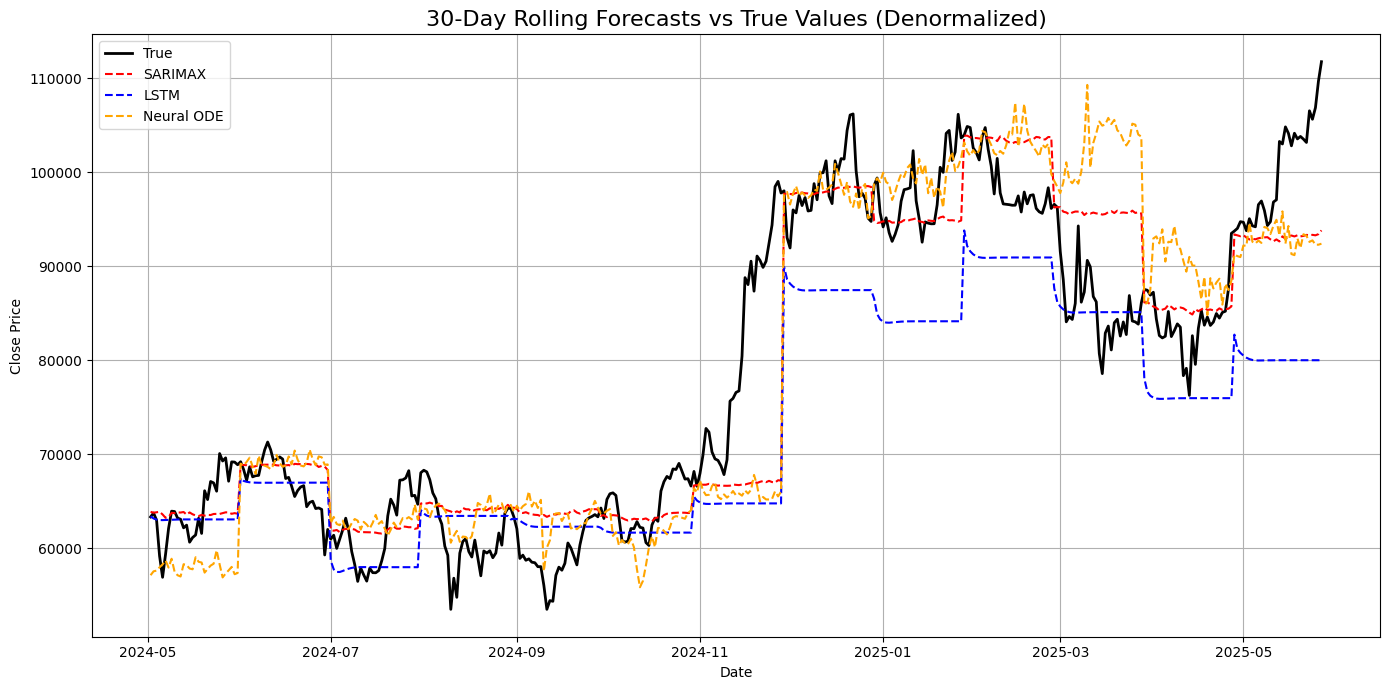

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def prepare_for_plot(data_list):
    """Converts a list of scalars or arrays into a single 1D numpy array for plotting."""
    return np.concatenate([np.atleast_1d(item) for item in data_list])

plt.figure(figsize=(14, 7))
plt.title('30-Day Rolling Forecasts vs True Values (Denormalized)', fontsize=16)

# Plot true values
plt.plot(prepare_for_plot(sarimax_rolling_dates), prepare_for_plot(true_rolling_denorm_30),
         label='True', color='black', linewidth=2)

# Plot SARIMAX predictions
plt.plot(prepare_for_plot(sarimax_rolling_dates), prepare_for_plot(sarimax_rolling_preds),
         label='SARIMAX', color='red', linestyle='--')

# Plot LSTM predictions
plt.plot(prepare_for_plot(lstm_rolling_dates), prepare_for_plot(lstm_rolling_preds),
         label='LSTM', color='blue', linestyle='--')

# Plot Neural ODE predictions
plt.plot(prepare_for_plot(ode_rolling_dates), prepare_for_plot(ode_rolling_preds),
         label='Neural ODE', color='orange', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# import numpy as np

# # Trim ode_rolling_preds_7 to same number of blocks as ode_rolling_preds
# ode_rolling_preds_7_trimmed = ode_rolling_preds_7[:len(ode_rolling_preds)]

# # Now compare
# first_7_from_30 = [pred[:7] for pred in ode_rolling_preds]

# # Print the flattened arrays being compared
# print("First 7 values from each pred in ode_rolling_preds (flattened):")
# print(np.concatenate(first_7_from_30))

# print("\nTrimmed ode_rolling_preds_7 (flattened):")
# print(np.concatenate(ode_rolling_preds_7_trimmed))

# # Compare the values
# print("\nAll close comparison result:")
# print(np.allclose(np.concatenate(first_7_from_30), np.concatenate(ode_rolling_preds_7_trimmed)))


In [ ]:
# import pandas as pd

# # Save each prepared series
# def save_series_to_csv(series, filename):
#     array_1d = prepare_for_plot(series)
#     pd.Series(array_1d).to_csv(filename, index=False)

# # Save the true values
# save_series_to_csv(true_rolling_denorm_7, "true_rolling_norm_7.csv")
# save_series_to_csv(true_rolling_denorm_30, "true_rolling_norm_30.csv")
# save_series_to_csv(true_rolling_denorm_90, "true_rolling_norm_90.csv")
# save_series_to_csv(true_rolling_denorm_1, "true_rolling_norm_1.csv")

# # Save SARIMAX forecasts
# save_series_to_csv(sarimax_rolling_preds_90, "sarimax_preds_90.csv")
# save_series_to_csv(sarimax_rolling_preds,    "sarimax_preds_30.csv")
# save_series_to_csv(sarimax_rolling_preds_7,  "sarimax_preds_7.csv")
# save_series_to_csv(sarimax_rolling_preds_1,  "sarimax_preds_1.csv")

# # Save LSTM forecasts
# save_series_to_csv(lstm_rolling_preds_90, "lstm_preds_90.csv")
# save_series_to_csv(lstm_rolling_preds,    "lstm_preds_30.csv")
# save_series_to_csv(lstm_rolling_preds_7,  "lstm_preds_7.csv")
# save_series_to_csv(lstm_rolling_preds_1,  "lstm_preds_1.csv")

# # Save Neural ODE forecasts
# save_series_to_csv(ode_rolling_preds_90, "ode_preds_90.csv")
# save_series_to_csv(ode_rolling_preds,    "ode_preds_30.csv")
# save_series_to_csv(ode_rolling_preds_7,  "ode_preds_7.csv")
# save_series_to_csv(ode_rolling_preds_1,  "ode_preds_1.csv")


In [ ]:
# Save each prepared series
def save_series_to_csv(series, filename):
    array_1d = prepare_for_plot(series)
    pd.Series(array_1d).to_csv(filename, index=False)

save_series_to_csv(true_rolling_denorm_30, "true_rolling_denorm_30_fgi.csv")
save_series_to_csv(sarimax_rolling_preds,    "sarimax_preds_30_fgi.csv")
save_series_to_csv(lstm_rolling_preds,    "lstm_preds_30_fgi.csv")
save_series_to_csv(ode_rolling_preds,    "ode_preds_30_fgi.csv")



In [ ]:
save_series_to_csv(ode_rolling_dates, "ode_rolling_dates.csv")
save_series_to_csv(sarimax_rolling_dates, "sarimax_rolling_dates.csv")
save_series_to_csv(lstm_rolling_dates, "lstm_rolling_dates.csv")

In [ ]:
save_series_to_csv(true_rolling_norm_30, "true_rolling_norm_30.csv")
save_series_to_csv(sarimax_rolling_preds_norm, "sarimax_preds_norm_fgi.csv")
save_series_to_csv(lstm_rolling_preds_norm, "lstm_preds_norm_fgi.csv")
save_series_to_csv(ode_rolling_preds_norm, "ode_preds_norm_fgi.csv")

In [ ]:
# class ODEFunc(nn.Module):
#     def __init__(self, input_dim, hidden_dim):
#         super(ODEFunc, self).__init__()
#         self.input_layer = nn.Linear(input_dim, hidden_dim)
#         self.hidden_layer = nn.Linear(hidden_dim, hidden_dim)

#     def forward(self, t, h):
#         h = torch.tanh(self.input_layer(h))
#         return self.hidden_layer(h)

# class NeuralODE(nn.Module):
#     def __init__(self, ode_func):
#         super(NeuralODE, self).__init__()
#         self.ode_func = ode_func

#     def forward(self, h0, t):
#         return odeint(self.ode_func, h0, t)